In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata


from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess

## Read the phages

Note that the `read_phages()` function filters to <100 contigs by default

In [2]:
df = read_phages()

Please note that this was run with git commit 1a2a28b that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages, but after filtering we kept 1,961,109 prophages from 388,797 genomes

In [3]:
df['fraction pp'] = df['bp prophage']/df['Genome length']
df

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,fraction pp
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.000000
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,0.061346
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,0.144217
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,0.023096
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,0.044088
...,...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0,0.043722
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0,0.036061
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0,0.058836
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0,0.058840


## Compare genome length and prophage bp

Use statistics!

In [4]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 3.388e+05
Date:                Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                        14:28:45   Log-Likelihood:            -4.8091e+06
No. Observations:              388797   AIC:                         9.618e+06
Df Residuals:                  388795   BIC:                         9.618e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.738e+04    273.709    -63.494      0.000   -1.79e+04   -1.68e+04
Genome length     0.0382   6.57e-05    582.044      0.000       0.038       0.038
==============================================================================
Omnibus:                    47174.874   Durbin-Watson:                   1.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           288647.782
Skew:                           0.423   Prob(JB):                         0.00
Kurtosis:                       7.136   Cond. No.                     1.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.038x + -17378.755
The R-squared is 0.466
The p-value for genome length is 0.000


In [6]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

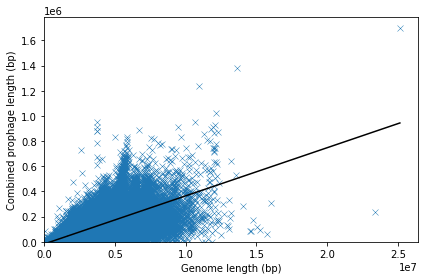

In [7]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [8]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                 2.479e+05
Date:                Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                        14:42:40   Log-Likelihood:            -8.9932e+05
No. Observations:              388797   AIC:                         1.799e+06
Df Residuals:                  388795   BIC:                         1.799e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4689      0.012    -39.915      0.000      -0.492      -0.446
Genome length  1.403e-06   2.82e-09    497.848      0.000     1.4e-06    1.41e-06
==============================================================================
Omnibus:                    39230.011   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115573.356
Skew:                           0.546   Prob(JB):                         0.00
Kurtosis:                       5.437   Cond. No.                     1.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 1.4033341834058488e-06x + -0.469
The R-squared is 0.389
The p-value for genome length is 0.000


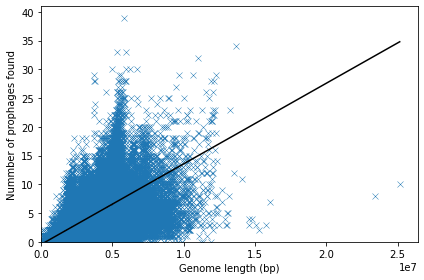

In [10]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 22480.020x + 19402.477
The R-squared is 0.815
The p-value for number of phages kept is 0.000


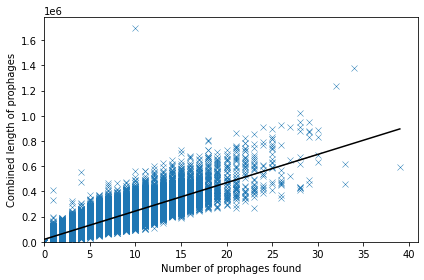

In [11]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [12]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.147x + 25.623
The R-squared is 0.055
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.033x + 3.477
The R-squared is 0.068
The p-value for number of phages kept is 0.000


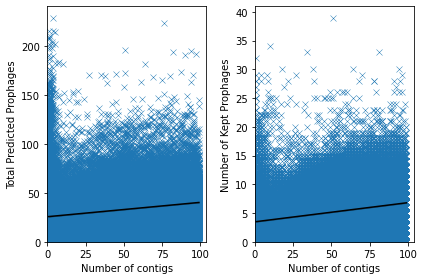

In [13]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

How many contigs are there?

(-10.0, 25.0)

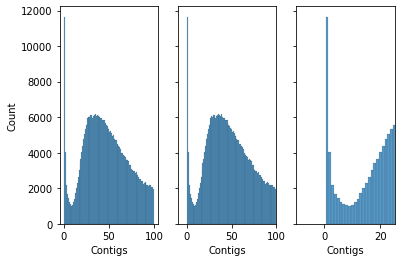

In [14]:
fig, ax =plt.subplots(ncols=3, sharey=True)
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[0])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[1])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[2])
ax[1].set_xlim(-10, 100)
ax[2].set_xlim(-10, 25)

#### Repeating, but only for genomes > 20 contigs

I think the graph is being strongly skewed at the bottom.

In [15]:
ndraft = 20
print(f"There are {sum(df['Contigs'] < ndraft):,} contigs less than {ndraft} contigs")

There are 47,936 contigs less than 20 contigs



For TOTAL prophages in draft genomes > 20 contigs
The equation is 0.149x +b 25.567 and r**2=0.046

For KEPT prophages
The equation is 0.031x + 3.660 and r**2=0.042


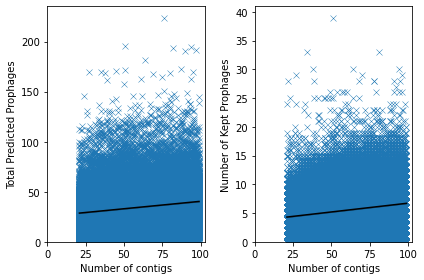

In [16]:
dfdrafts = df[df['Contigs'] > ndraft].copy()
dfdrafts.drop(['contigs vs kept pp', 'contigs vs total pp'], axis=1)
exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Total Predicted Prophages"], exog).fit()
print(f"\nFor TOTAL prophages in draft genomes > {ndraft} contigs")
print(f"The equation is {model.params['Contigs']:.3f}x +b {model.params['const']:.3f} and r**2={model.rsquared:.3f}")

dfdrafts['contigs vs total pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")
dfdrafts['contigs vs kept pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=dfdrafts, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=dfdrafts, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=dfdrafts, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=dfdrafts, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/draftcontigspp.png')

# Filter to sequences with less than 20 contigs

In [17]:
ndraft=20
df = df[df['Contigs'] < ndraft].copy()
df.shape

(47936, 16)

## Some general data about the prophages

In [18]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 3.53 prophages per genome on average, with a mean combined length of 112,608 bp, so 31,860 bp per prophage


In [19]:
print(f"The most prophages is {max(df['Kept'])} in {df.iloc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.iloc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.iloc[df['fraction pp'].argmax()]['Contig']}")

KeyError: 'Contig'

In [ ]:
ax = sns.histplot(df['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")

# Filtered Data Set

Lets filter out anything in more than 10 contigs. This should be essentially complete genomes and remove any bias from fragmented genomes

In [ ]:
filtermax=10
print(f"Before filtering we have {df.shape[0]:,} genomes")
fdf = df[df['Contigs'] < filtermax].copy()
fdf.reset_index().drop('index', axis=1)
print(f"After filtering for genomes with less than {filtermax} contigs we have {fdf.shape[0]:,} genomes")

In [ ]:
print(f"After filtering for genomes with less than {filtermax} contigs")
print(f"There are {fdf['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {fdf['bp prophage'].mean():,.0f} bp, so {fdf['bp prophage'].mean()/fdf['Kept'].mean():,.0f} bp per prophage")

In [ ]:
print(f"The most prophages is {max(fdf['Kept'])} in {fdf.iloc[fdf['Kept'].argmax()]['Contig']} that has {fdf.iloc[fdf['Kept'].argmax()]['Contigs']} contigs")
print(f"The longest combined amount of prophage DNA is {max(fdf['bp prophage'])} in {fdf.iloc[fdf['bp prophage'].argmax()]['Contig']} that has {fdf.iloc[fdf['bp prophage'].argmax()]['Contigs']} contigs")
print(f"The highest fraction of prophage DNA is {max(fdf['fraction pp']) * 100:.3f}% in {fdf.iloc[fdf['fraction pp'].argmax()]['Contig']}")

In [ ]:
ax = sns.histplot(fdf['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")
fig = ax.get_figure()
fig.savefig('images/pp_hist.png')

### There is no dependency on number of contigs now

When we drop highly fragmented (draft) genomes, we loose the dependency on the number of contigs completely.

In [ ]:
fdf.drop(['contigs vs total pp', 'contigs vs kept pp'], axis=1)

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs total pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs kept pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=fdf, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=fdf, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=fdf, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=fdf, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/filteredcontigspp.png')

# Size distributions

This is mostly for Toni Luque who is really interested in the size distributions of the prophages.